## Imports, Settings, & Functions

In [11]:
import cv2
import PIL.Image as Image
import os
from scipy.io import loadmat
import numpy as np
from scipy.io.matlab import mat_struct
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

In [12]:
root_dir = "/home/linux-pc/gh/projects/NeuralNexus/New-Features/Thought-to-Image/V1-Visual-Cortex-Visualization"
data_root_dir = root_dir + "/data/crcns-pvc1/crcns-ringach-data/"
movie_root_dir = "movie_frames/movie000_000.images/"
current_movie = "movie000_000_000.jpeg"
neuro_root_dir = "neurodata/ac1/"
current_neuro_data = "ac1_u004_000.mat"


In [13]:
movie_frame_path = '/home/linux-pc/gh/projects/NeuralNexus/New-Features/Thought-to-Image/V1-Visual-Cortex-Visualization/data/crcns-pvc1/crcns-ringach-data/movie_frames/movie000_000.images/movie000_000_000.jpeg'

In [14]:
def matlab_to_python(obj):
    """Recursively convert MATLAB structs and cell arrays to Python dicts/lists."""
    if isinstance(obj, mat_struct):
        return {field: matlab_to_python(getattr(obj, field)) for field in obj._fieldnames}
    elif isinstance(obj, np.ndarray):
        # Handle MATLAB cell arrays
        if obj.dtype == object:
            return [matlab_to_python(el) for el in obj.flat]
        else:
            return obj
    elif isinstance(obj, list):
        return [matlab_to_python(el) for el in obj]
    else:
        return obj


In [22]:
def analyze_waveform(pepANA_clean, condition, verbose=False):
    """
    Analyze SVD of waveforms from a specific condition and electrode in pepANA.

    Parameters:
        pepANA_clean: dict - Unpacked MATLAB structure from loadmat
        condition: int - Index of the condition (0-based)
        electrode: int - Index of the electrode (0-based)
        verbose: bool - Whether to show plots

    Returns:
        signal_idx: np.ndarray - Indices of waveforms classified as signal
    """

    # Extract waveform matrix [time x waveforms]
    waveforms = pepANA_clean["listOfResults"][condition]["repeat"]["data"][0][1]
    waveforms = np.array(waveforms, dtype=np.float64)  # Ensure float precision

    # Perform SVD
    u, s, vT = np.linalg.svd(waveforms, full_matrices=False)  # vT: shape [n_waveforms, n_waveforms]

    # Projection into first 2 principal components
    projections = vT.T[:, :2]  # shape: [n_waveforms, 2]

    # Plot SVD projections
    if verbose:
        plt.figure(figsize=(8, 6))
        plt.scatter(projections[:, 0], projections[:, 1], s=10)
        plt.plot(0, 0, 'r.', markersize=25)
        plt.title(f"SVD Projection: Condition {condition+1}")
        plt.xlabel("1st Principal Component")
        plt.ylabel("2nd Principal Component")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Cluster using k-means on waveforms
    km = KMeans(n_clusters=2, random_state=0)
    cluster_labels = km.fit_predict(waveforms.T)  # waveforms.T: shape [n_waveforms x time]

    # Separate clusters
    idx1 = np.where(cluster_labels == 0)[0]
    idx2 = np.where(cluster_labels == 1)[0]

    # Compare total amplitude to identify signal vs noise
    mean1 = np.mean(waveforms[:, idx1], axis=1)
    mean2 = np.mean(waveforms[:, idx2], axis=1)

    amp1 = np.sum(np.abs(mean1))
    amp2 = np.sum(np.abs(mean2))

    if amp1 > amp2:
        signal_idx = idx1
        noise_idx = idx2
    else:
        signal_idx = idx2
        noise_idx = idx1

    # Detailed plotting if verbose
    if verbose:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        ax1.scatter(projections[noise_idx, 0], projections[noise_idx, 1], color='b', s=10, label="Noise")
        ax1.scatter(projections[signal_idx, 0], projections[signal_idx, 1], color='g', s=10, label="Signal")
        ax1.plot(0, 0, 'r.', markersize=25)
        ax1.set_title("SVD Clustering")
        ax1.set_xlabel("1st PC")
        ax1.set_ylabel("2nd PC")
        ax1.legend()
        ax1.grid(True)

        # Plot error bars of signal and noise mean traces
        timepoints = np.arange(waveforms.shape[0])
        signal_waveforms = waveforms[:, signal_idx].T
        noise_waveforms = waveforms[:, noise_idx].T

        ax2.errorbar(
            timepoints,
            np.mean(signal_waveforms, axis=0),
            yerr=np.std(signal_waveforms, axis=0),
            label="Signal", color='g'
        )
        ax2.errorbar(
            timepoints,
            np.mean(noise_waveforms, axis=0),
            yerr=np.std(noise_waveforms, axis=0),
            label="Noise", color='b'
        )
        ax2.set_xlim([0, 49])
        ax2.set_title("Mean Waveform with Std Dev")
        ax2.set_xlabel("Time")
        ax2.set_ylabel("Amplitude")
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        plt.show()

    return signal_idx



### Testing image data load

In [7]:
image = cv2.imread(movie_frame_path, cv2.IMREAD_COLOR)
cv2.imshow("Image", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
image = Image.open(movie_frame_path)
image.show()

### Testing neural data load

In [36]:
neuro_data_path = os.path.join(data_root_dir, neuro_root_dir, current_neuro_data)
mat = loadmat(neuro_data_path, struct_as_record=False, squeeze_me=True)
pepANA = mat["pepANA"]
pepANA_clean = matlab_to_python(pepANA)


In [68]:
# Total Number of Conditions
pepANA_clean["no_conditions"]

120

In [70]:
# Arrival Times for electrodes in pepANA.electrode_list
pepANA_clean["listOfResults"][0]["repeat"]["data"][12]

[array([ 0.35366667,  0.4543    ,  0.60363333,  0.67803333,  1.0123    ,
         1.1758    ,  1.1779    ,  1.19143333,  1.41263333,  1.4425    ,
         1.53376667,  1.6866    ,  1.96616667,  2.58276667,  2.94513333,
         3.30116667,  3.77443333,  3.93216667,  4.02006667,  4.64913333,
         4.6791    ,  4.70383333,  4.7153    ,  4.7283    ,  4.75303333,
         4.94533333,  5.01136667,  5.07016667,  5.15706667,  5.2284    ,
         5.245     ,  5.253     ,  5.27926667,  5.31243333,  5.4489    ,
         5.4555    ,  5.5446    ,  5.61203333,  5.6444    ,  5.90743333,
         5.94473333,  6.0529    ,  6.1861    ,  6.44473333,  6.46576667,
         6.4674    ,  6.59466667,  6.63643333,  6.7368    ,  6.73946667,
         6.7992    ,  7.18606667,  7.20756667,  7.2251    ,  7.41163333,
         7.41746667,  7.4342    ,  7.44093333,  7.73663333,  7.73826667,
         7.74266667,  7.76023333,  7.77516667,  7.9908    ,  7.99876667,
         8.09113333,  8.12836667,  8.28683333,  8.2

In [84]:
# Detected Waveforms at that time
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

(48, 573)

In [83]:
# Times since initial waveform is detected. (48 samples of waveform snippets)
# (Contains spikes and noise bc of low threshold 
# (1.6ms sampled at 30kHz at int8 precision)) 

pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0].shape

(573,)

In [87]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]

array([ 0.4543    ,  0.54653333,  0.8413    ,  0.89186667,  1.03033333,
        1.04676667,  1.09213333,  1.0955    ,  1.09746667,  1.1127    ,
        1.13403333,  1.1364    ,  1.14606667,  1.15046667,  1.15356667,
        1.16586667,  1.1676    ,  1.17283333,  1.18453333,  1.1907    ,
        1.19573333,  1.20813333,  1.21143333,  1.22073333,  1.24616667,
        1.32046667,  1.75046667,  1.7624    ,  2.01243333,  2.01936667,
        2.67033333,  2.8907    ,  2.9705    ,  3.15436667,  3.20806667,
        3.2501    ,  3.8376    ,  3.8666    ,  3.86956667,  3.87256667,
        3.87496667,  3.88076667,  3.8824    ,  3.88836667,  3.8904    ,
        3.89293333,  3.89586667,  3.93376667,  3.9362    ,  3.93806667,
        3.9412    ,  3.94466667,  3.94906667,  3.95336667,  3.99106667,
        4.12813333,  4.2129    ,  4.32813333,  4.5963    ,  4.609     ,
        4.62863333,  4.63126667,  4.66576667,  4.67966667,  4.68656667,
        4.69513333,  4.70383333,  4.71063333,  4.7297    ,  4.74

In [91]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][0]

array([[  0,  -6,  -2, ...,  17,  -7, -10],
       [ -1,  -3,  -2, ...,  13, -13,  -7],
       [  3,  -3,  -2, ...,  12, -19,   1],
       ...,
       [ 13,   3,  -6, ..., -12,  -1,   2],
       [ 15,   1,  -3, ...,  -7,  -7,   1],
       [  7,  -5,  -3, ...,   0,  -7,   3]], dtype=int8)

In [93]:
x = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]

In [103]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

(48, 573)

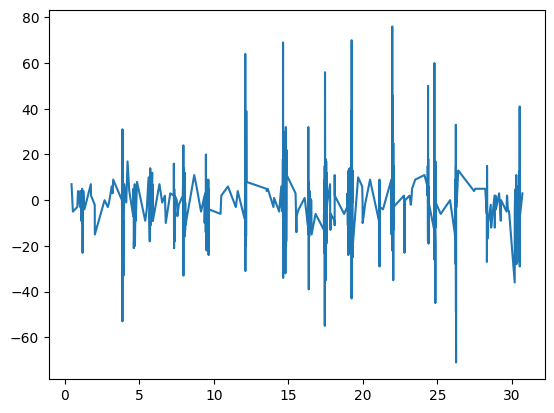

In [102]:
import matplotlib.pyplot as plt
plt.plot(x, pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][47])

In [213]:
import numpy as np
import matplotlib.pyplot as plt

# Extract waveform data and spike times
waveforms = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1]  # (48, 573)
arrival_times = pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0]  # (573,)


In [ ]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0]

array([ 0.4543    ,  0.54653333,  0.8413    ,  0.89186667,  1.03033333,
        1.04676667,  1.09213333,  1.0955    ,  1.09746667,  1.1127    ,
        1.13403333,  1.1364    ,  1.14606667,  1.15046667,  1.15356667,
        1.16586667,  1.1676    ,  1.17283333,  1.18453333,  1.1907    ,
        1.19573333,  1.20813333,  1.21143333,  1.22073333,  1.24616667,
        1.32046667,  1.75046667,  1.7624    ,  2.01243333,  2.01936667,
        2.67033333,  2.8907    ,  2.9705    ,  3.15436667,  3.20806667,
        3.2501    ,  3.8376    ,  3.8666    ,  3.86956667,  3.87256667,
        3.87496667,  3.88076667,  3.8824    ,  3.88836667,  3.8904    ,
        3.89293333,  3.89586667,  3.93376667,  3.9362    ,  3.93806667,
        3.9412    ,  3.94466667,  3.94906667,  3.95336667,  3.99106667,
        4.12813333,  4.2129    ,  4.32813333,  4.5963    ,  4.609     ,
        4.62863333,  4.63126667,  4.66576667,  4.67966667,  4.68656667,
        4.69513333,  4.70383333,  4.71063333,  4.7297    ,  4.74

In [214]:

# Parameters
n_waveforms = waveforms.shape[1]
n_samples = waveforms.shape[0]

In [215]:


sampling_rate = 30_000  # Hz
offset = 200  # vertical spacing between waveforms
time_axis = np.arange(n_samples) / sampling_rate * 1_000  # in milliseconds (0–1.6 ms)


In [218]:
n_waveforms

573

In [230]:
waveform_t = (arrival_times[0] + np.arange(n_samples) / 30000)

In [216]:
n_samples

48

In [224]:
arrival_times[0]

0.4543

In [222]:
waveforms[:,0]

array([  0,  -1,   3,   1,   1,   2,   0,  -9, -19, -24, -16, -11, -17,
       -14,  -9,   1,  -3,  -7,   0,   2,  -1,  -3,   0,   9,   9,   5,
         4,   1,  -6,  -7,  -4,  -3,  -8,  -9,   1,   0,  -5,   0,   3,
         1,   3,   8,   5,   4,   7,  13,  15,   7], dtype=int8)

In [390]:
waveforms.shape[1]

573

In [638]:
t = 0

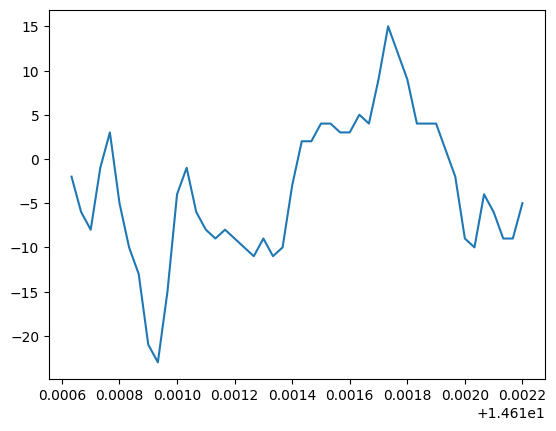

In [851]:
t += 1
t = t % waveforms.shape[1]
waveform_t = (arrival_times[t] + np.arange(n_samples) / 30000)
plt.plot(waveform_t, waveforms[:,t])

In [195]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

(48, 573)

In [204]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][0]

0.4543

In [200]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][:, 0]

array([  0,  -1,   3,   1,   1,   2,   0,  -9, -19, -24, -16, -11, -17,
       -14,  -9,   1,  -3,  -7,   0,   2,  -1,  -3,   0,   9,   9,   5,
         4,   1,  -6,  -7,  -4,  -3,  -8,  -9,   1,   0,  -5,   0,   3,
         1,   3,   8,   5,   4,   7,  13,  15,   7], dtype=int8)

In [ ]:
plt.plot()

In [208]:
573

573

## SVD of Waveforms

In [17]:
neuro_data_path = os.path.join(data_root_dir, neuro_root_dir, current_neuro_data)
mat = loadmat(neuro_data_path, struct_as_record=False, squeeze_me=True)
pepANA = mat["pepANA"]
pepANA_clean = matlab_to_python(pepANA)


In [18]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1].shape

(48, 573)

In [19]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0].shape

(573,)

In [20]:
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][:5]

array([0.4543    , 0.54653333, 0.8413    , 0.89186667, 1.03033333])

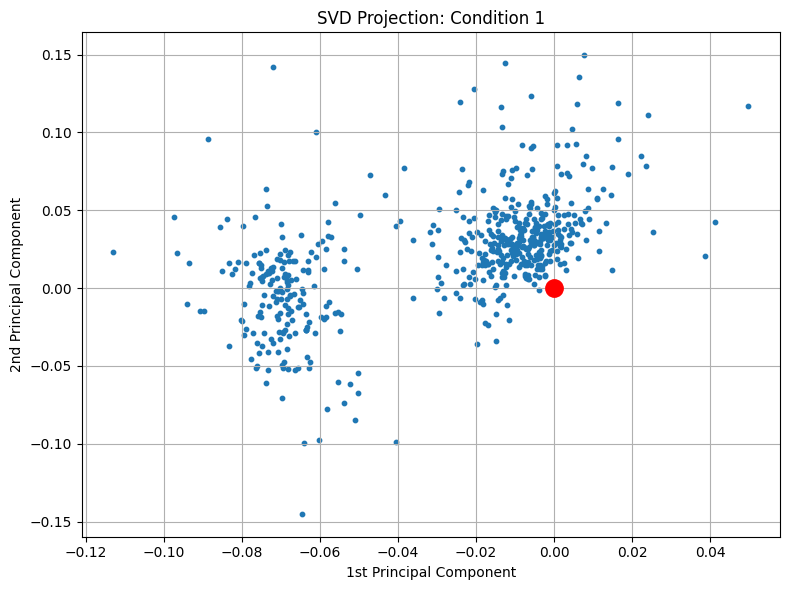

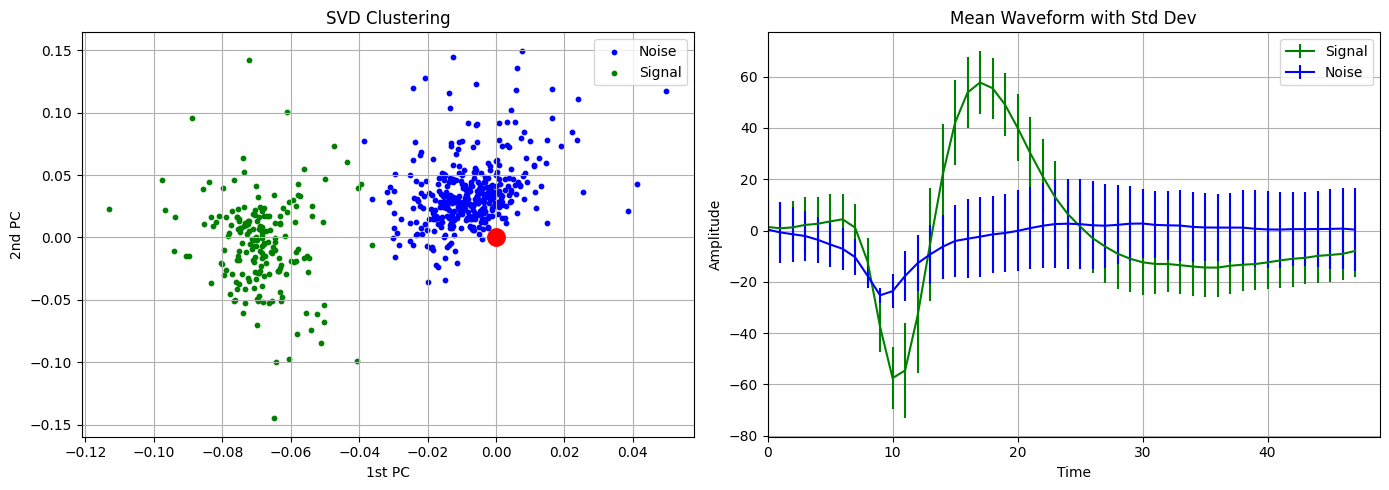

In [23]:
signal_idx = analyze_waveform(pepANA_clean, 0, verbose=True)

In [24]:
signal_idx.__len__()

192

In [25]:
# Arrival Times of Detected Signals
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][0][signal_idx]

array([ 1.09746667,  1.1127    ,  1.1364    ,  1.15356667,  1.16586667,
        1.17283333,  1.1907    ,  1.21143333,  3.87496667,  3.89586667,
        3.93806667,  3.94466667,  3.94906667,  4.609     ,  4.63126667,
        4.66576667,  4.71063333,  4.7297    ,  4.7665    ,  5.69403333,
        5.70726667,  5.72216667,  5.73463333,  5.75196667,  5.76383333,
        5.7932    ,  5.87683333,  5.88823333,  5.89403333,  5.90233333,
        5.91293333,  6.77666667,  7.31703333,  7.33973333,  7.35316667,
        7.36906667,  7.55703333,  7.9591    ,  7.97086667,  8.01926667,
        8.02253333,  8.0277    ,  8.03076667,  8.0344    ,  8.07703333,
        8.09953333,  9.38553333,  9.4472    ,  9.463     ,  9.47583333,
        9.4922    ,  9.50883333,  9.521     ,  9.53536667,  9.55073333,
        9.5611    ,  9.63706667,  9.65336667,  9.65896667,  9.6708    ,
       12.1       , 12.1067    , 12.1176    , 12.16373333, 12.17026667,
       14.64196667, 14.65796667, 14.8047    , 14.82553333, 14.83

In [28]:
# Waveforms that are 48 samples long that are verifiably signal
pepANA_clean["listOfResults"][0]["repeat"]["data"][0][1][:, signal_idx]

array([[ 10,  -7,   4, ..., -10,  -6,  -7],
       [ -2,  -4,   7, ...,  -7,  -8, -13],
       [ -8,  -2,   6, ...,   1,  -6, -19],
       ...,
       [-12,  -7, -16, ...,   0,  -1,  -1],
       [-12,   0,  -9, ...,  -1,   2,  -7],
       [ -9,   4,  -7, ...,  -3,   4,  -7]], dtype=int8)

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_signal_waveforms_aligned(pepANA_clean, condition, signal_idx, electrode=0, sampling_rate=30000.0):
    """
    Plot each waveform in `signal_idx` aligned to its actual time points.

    Parameters:
        pepANA_clean : dict
            MATLAB structure loaded via scipy.io.loadmat
        condition : int
            Index into the listOfResults (0-based)
        signal_idx : array-like
            Indices of signal-classified waveforms
        electrode : int
            Which electrode (0-based index into .data)
        sampling_rate : float
            Sampling rate in Hz (default 30 kHz)
    """

    arrival_times = pepANA_clean["listOfResults"][condition]["repeat"]["data"][electrode][0]  # shape: (N,)
    waveforms = pepANA_clean["listOfResults"][condition]["repeat"]["data"][electrode][1]       # shape: (48, N)

    # Constants
    waveform_length = waveforms.shape[0]                   # 48 samples
    time_step = 1.0 / sampling_rate                        # e.g., 1 / 30000 seconds

    plt.figure(figsize=(12, 8))

    for idx in signal_idx:
        t0 = arrival_times[idx]                            # starting time of spike
        waveform = waveforms[:, idx]
        t_waveform = t0 + np.arange(waveform_length) * time_step  # 48 time samples starting at t0

        plt.plot(t_waveform * 1000, waveform, alpha=0.4)   # convert to ms

    plt.xlabel("Time (ms)")
    plt.ylabel("Amplitude (int8 units)")
    plt.title(f"Signal-Aligned Waveforms (n={len(signal_idx)})")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


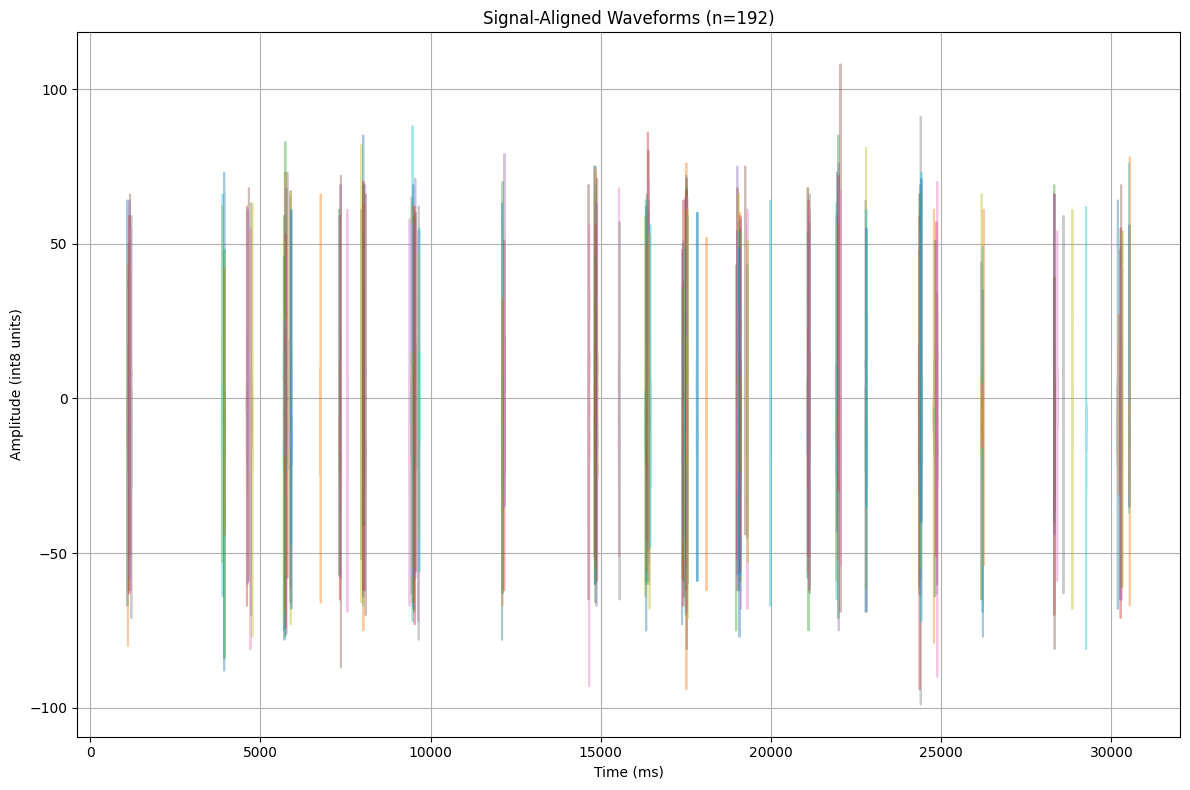

In [31]:
plot_signal_waveforms_aligned(pepANA_clean, 0, signal_idx, electrode=0, sampling_rate=30000.0)